# Pokedex using CNN

In [10]:
# import libraries

import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import PIL
import PIL.Image

## Data setup

In [49]:
data_dir = pathlib.Path('datasets/pokemon_dataset/pokemon_jpg/').with_suffix('')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

819


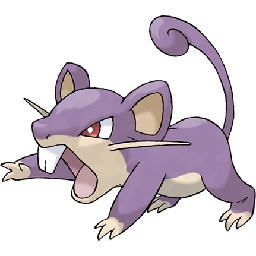

In [53]:
pokemons = list(data_dir.glob('*/*'))
PIL.Image.open(str(pokemons[0]))

In [54]:
# Creating dataset
batch_size = 32
img_height = 180
img_width = 180

# training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 819 files belonging to 1 classes.
Using 656 files for training.
Found 819 files belonging to 1 classes.
Using 163 files for validation.


In [75]:
class_names = train_ds.class_names
print(class_names)

['pokemon_jpg']


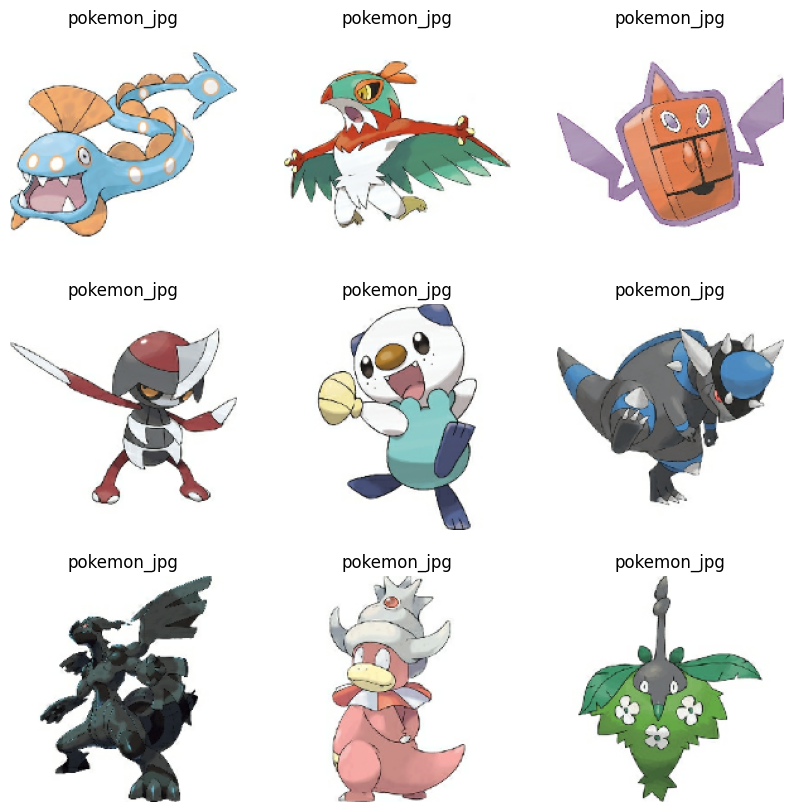

In [84]:
# visualize pokemons

plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(train_ds):
    if i >= 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[0])
    plt.axis("off")